<a href="https://colab.research.google.com/github/aakanksha215/EyeDiseaseClassificationSystem/blob/main/EyeDiseaseClassificationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading the Dataset**

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

In [ ]:
!unzip '*.zip' -d dataset

In [ ]:
import os
os.listdir()

['.config',
 'dataset',
 'eye-diseases-classification.zip',
 'kaggle.json',
 'sample_data']

In [ ]:
dataset_path = "/content/dataset/dataset/"
classes = os.listdir(dataset_path)

In [ ]:
classes

['diabetic_retinopathy', 'normal', 'glaucoma', 'cataract']

In [ ]:
lst = list()
for cls in classes:
  class_path = os.path.join(dataset_path, cls)
  img_list = os.listdir(class_path)
  lst.append(len(img_list))
  print("Class Name:", cls ,"contains" ,len(img_list) ,"images.")

Class Name: diabetic_retinopathy contains 1098 images.
Class Name: normal contains 1074 images.
Class Name: glaucoma contains 1007 images.
Class Name: cataract contains 1038 images.


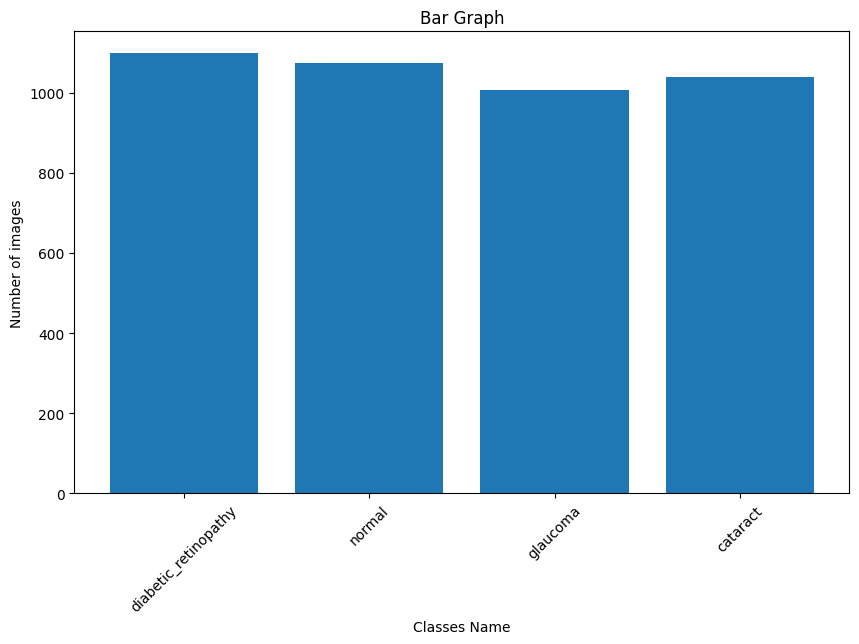

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.bar(classes, lst)
plt.xticks(rotation=45)
plt.xlabel("Classes Name")
plt.ylabel("Number of images")
plt.title("Bar Graph")
plt.show()

In [ ]:
import cv2

for cls in classes:
  class_path = os.path.join(dataset_path, cls)
  img_list = os.listdir(class_path)

  image_path = os.path.join(class_path, img_list[0])
  image = cv2.imread(image_path)

  print("For Class:",cls,"image has shape:",image.shape)

For Class: diabetic_retinopathy image has shape: (512, 512, 3)
For Class: normal image has shape: (512, 512, 3)
For Class: glaucoma image has shape: (256, 256, 3)
For Class: cataract image has shape: (512, 512, 3)


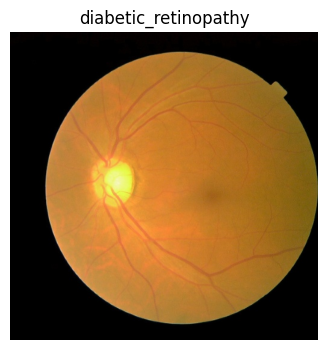

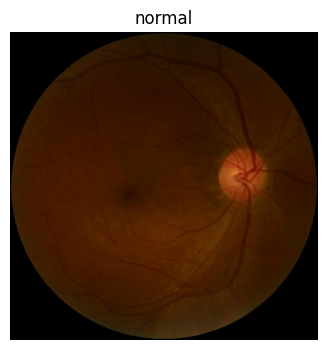

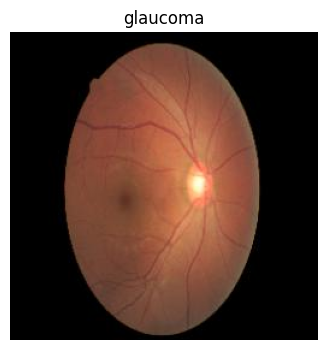

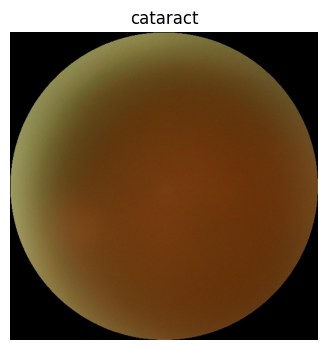

In [ ]:
for cls in classes:
  class_path = os.path.join(dataset_path, cls)
  img_list = os.listdir(class_path)

  image_path = os.path.join(class_path, img_list[0])
  image = cv2.imread(image_path)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  plt.figure(figsize=(6,4))
  plt.imshow(image)
  plt.title(cls)
  plt.axis("off")
  plt.show()

**Splitting the Dataset into Train, Validation and Test Subsets **

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

import os
import pandas as pd

data = []
base_dir = "/content/dataset/dataset"

for label in os.listdir(base_dir):
    label_dir = os.path.join(base_dir, label)
    for img in os.listdir(label_dir):
        data.append([img, label])

df = pd.DataFrame(data, columns=["image", "label"])

df["filepath"] = df.apply(
    lambda row: os.path.join(base_dir, row["label"], row["image"]),
    axis=1
)


train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=42,
    shuffle=True
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    shuffle=True
)

In [ ]:
train_df

,image,label,filepath
3848,_190_3033991.jpg,cataract,/content/dataset/dataset/cataract/_190_3033991...
3225,_395_8303850.jpg,cataract,/content/dataset/dataset/cataract/_395_8303850...
3182,_280_4533213.jpg,cataract,/content/dataset/dataset/cataract/_280_4533213...
3435,874_left.jpg,cataract,/content/dataset/dataset/cataract/874_left.jpg
3657,_126_1745653.jpg,cataract,/content/dataset/dataset/cataract/_126_1745653...
...,...,...,...
3444,2120_right.jpg,cataract,/content/dataset/dataset/cataract/2120_right.jpg
466,10974_right.jpeg,diabetic_retinopathy,/content/dataset/dataset/diabetic_retinopathy/...
3092,_94_8906983.jpg,glaucoma,/content/dataset/dataset/glaucoma/_94_8906983.jpg
3772,2106_right.jpg,cataract,/content/dataset/dataset/cataract/2106_right.jpg


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
val_gen = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 2951 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.


**Model Training**

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense,Activation, GlobalAveragePooling2D,Flatten,Conv2D, Dropout, BatchNormalization, Concatenate, Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [ ]:
base = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

for layer in base.layers:
    layer.trainable = False

for layer in base.layers[-150:]:
    layer.trainable = True


x = GlobalAveragePooling2D()(base.output)

x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(4, activation="softmax")(x)
model = Model(base.input, output)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_20   │ (None, 230, 230,  │          0 │ input_layer_13[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_21   │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_2… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,301,956 (27.85 MB)

 Trainable params: 3,626,884 (13.84 MB)

 Non-trainable params: 3,675,072 (14.02 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath="best_model_val_acc.h5",   # or .keras (recommended)
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[checkpoint_cb]
)

Epoch 1/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6117 - loss: 1.0292
Epoch 1: val_accuracy improved from -inf to 0.79937, saving model to best_model_val_acc.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.6128 - loss: 1.0263 - val_accuracy: 0.7994 - val_loss: 0.5371
Epoch 2/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.8271 - loss: 0.4543
Epoch 2: val_accuracy improved from 0.79937 to 0.86098, saving model to best_model_val_acc.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 64s 686ms/step - accuracy: 0.8271 - loss: 0.4544 - val_accuracy: 0.8610 - val_loss: 0.3784
Epoch 3/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8531 - loss: 0.4046
Epoch 3: val_accuracy improved from 0.86098 to 0.86730, saving model to best_model_val_acc.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 57s 616ms/step - accuracy: 0.8532 - loss: 0.4043 - val_accuracy: 0.8673 - val_loss: 0.4046
Epoch 4/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.8894 - loss: 0.3243
Epoch 4: val_accuracy improved from 0.86730 to 0.88152, saving model to best_model_val_acc.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 59s 630ms/step - accuracy: 0.8895 - loss: 0.3240 - val_accuracy: 0.8815 - val_loss: 0.3341
Epoch 5/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9093 - loss: 0.2489
Epoch 5: val_accuracy improved from 0.88152 to 0.88784, saving model to best_model_val_acc.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 60s 646ms/step - accuracy: 0.9092 - loss: 0.2491 - val_accuracy: 0.8878 - val_loss: 0.3640
Epoch 6/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.9202 - loss: 0.2365
Epoch 6: val_accuracy did not improve from 0.88784
93/93 ━━━━━━━━━━━━━━━━━━━━ 58s 618ms/step - accuracy: 0.9201 - loss: 0.2366 - val_accuracy: 0.8673 - val_loss: 0.4586
Epoch 7/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.9175 - loss: 0.2406
Epoch 7: val_accuracy improved from 0.88784 to 0.89573, saving model to best_model_val_acc.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 58s 621ms/step - accuracy: 0.9175 - loss: 0.2406 - val_accuracy: 0.8957 - val_loss: 0.3004
Epoch 8/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.9290 - loss: 0.2154
Epoch 8: val_accuracy improved from 0.89573 to 0.90363, saving model to best_model_val_acc.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 58s 624ms/step - accuracy: 0.9290 - loss: 0.2154 - val_accuracy: 0.9036 - val_loss: 0.2859
Epoch 9/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9338 - loss: 0.1870
Epoch 9: val_accuracy did not improve from 0.90363
93/93 ━━━━━━━━━━━━━━━━━━━━ 57s 615ms/step - accuracy: 0.9337 - loss: 0.1869 - val_accuracy: 0.8736 - val_loss: 0.4603
Epoch 10/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.9366 - loss: 0.2027
Epoch 10: val_accuracy did not improve from 0.90363
93/93 ━━━━━━━━━━━━━━━━━━━━ 57s 611ms/step - accuracy: 0.9366 - loss: 0.2026 - val_accuracy: 0.9036 - val_loss: 0.2924
Epoch 11/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9340 - loss: 0.1781
Epoch 11: val_accuracy did not improve from 0.90363
93/93 ━━━━━━━━━━━━━━━━━━━━ 56s 606ms/step - accuracy: 0.9340 - loss: 0.1781 - val_accuracy: 0.8989 - val_loss: 0.3431
Epoch 12/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9547 - loss: 0.1285
Epoch 12: val_accuracy did

93/93 ━━━━━━━━━━━━━━━━━━━━ 57s 618ms/step - accuracy: 0.9725 - loss: 0.0859 - val_accuracy: 0.9100 - val_loss: 0.3472
Epoch 20/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9797 - loss: 0.0653
Epoch 20: val_accuracy improved from 0.90995 to 0.91311, saving model to best_model_val_acc.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 58s 615ms/step - accuracy: 0.9797 - loss: 0.0654 - val_accuracy: 0.9131 - val_loss: 0.3312
Epoch 21/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.9751 - loss: 0.0802
Epoch 21: val_accuracy improved from 0.91311 to 0.91469, saving model to best_model_val_acc.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 58s 622ms/step - accuracy: 0.9751 - loss: 0.0802 - val_accuracy: 0.9147 - val_loss: 0.3489
Epoch 22/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9720 - loss: 0.0730
Epoch 22: val_accuracy did not improve from 0.91469
93/93 ━━━━━━━━━━━━━━━━━━━━ 57s 611ms/step - accuracy: 0.9720 - loss: 0.0730 - val_accuracy: 0.8847 - val_loss: 0.4626
Epoch 23/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.9720 - loss: 0.0816
Epoch 23: val_accuracy did not improve from 0.91469
93/93 ━━━━━━━━━━━━━━━━━━━━ 56s 604ms/step - accuracy: 0.9721 - loss: 0.0815 - val_accuracy: 0.9052 - val_loss: 0.3541
Epoch 24/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.9814 - loss: 0.0568
Epoch 24: val_accuracy did not improve from 0.91469
93/93 ━━━━━━━━━━━━━━━━━━━━ 57s 616ms/step - accuracy: 0.9814 - loss: 0.0569 - val_accuracy: 0.8736 - val_loss: 0.5901
Epoch 25/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9803 - loss: 0.0675
Epoch 25: val_accuracy d

93/93 ━━━━━━━━━━━━━━━━━━━━ 58s 622ms/step - accuracy: 0.9822 - loss: 0.0572 - val_accuracy: 0.9226 - val_loss: 0.3817
Epoch 29/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.9775 - loss: 0.0633
Epoch 29: val_accuracy did not improve from 0.92259
93/93 ━━━━━━━━━━━━━━━━━━━━ 57s 611ms/step - accuracy: 0.9774 - loss: 0.0635 - val_accuracy: 0.8705 - val_loss: 0.5109
Epoch 30/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9790 - loss: 0.0686
Epoch 30: val_accuracy did not improve from 0.92259
93/93 ━━━━━━━━━━━━━━━━━━━━ 58s 624ms/step - accuracy: 0.9789 - loss: 0.0687 - val_accuracy: 0.9084 - val_loss: 0.3633
Epoch 31/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9782 - loss: 0.0618
Epoch 31: val_accuracy did not improve from 0.92259
93/93 ━━━━━━━━━━━━━━━━━━━━ 58s 621ms/step - accuracy: 0.9782 - loss: 0.0618 - val_accuracy: 0.8926 - val_loss: 0.4395
Epoch 32/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.9782 - loss: 0.0520
Epoch 32: val_accuracy d

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import load_model

model=load_model("/content/best_model_val_acc.h5")

**Calculating Training Loss, Validation Loss, Test Loss, Accuracy**

In [ ]:
# Training accuracy
train_loss, train_acc = model.evaluate(train_gen, verbose=0)

# Validation accuracy
val_loss, val_acc = model.evaluate(val_gen, verbose=0)

# Test accuracy
test_loss, test_acc = model.evaluate(test_gen, verbose=0)

print(f"Training Accuracy   : {train_acc*100:.2f}%")
print(f"Validation Accuracy : {val_acc*100:.2f}%")
print(f"Testing Accuracy    : {test_acc*100:.2f}%")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Training Accuracy   : 98.71%
Validation Accuracy : 92.26%
Testing Accuracy    : 92.26%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(generator, model, title):
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=list(generator.class_indices.keys())
    )
    disp.plot(cmap="Blues")
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()


93/93 ━━━━━━━━━━━━━━━━━━━━ 53s 566ms/step


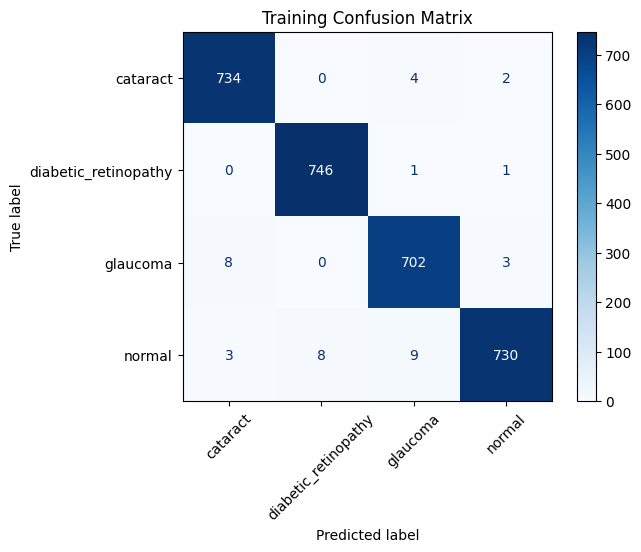

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step


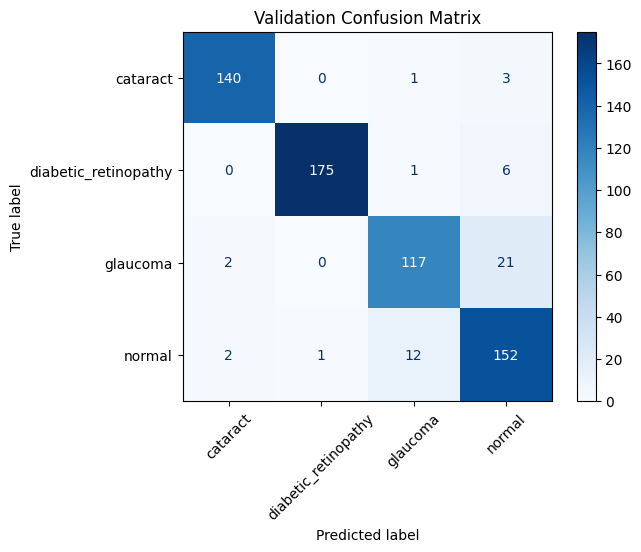

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step


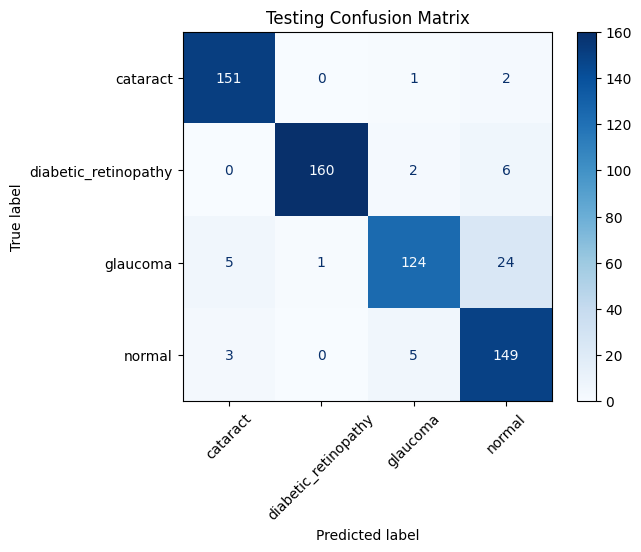

In [ ]:
plot_confusion_matrix(train_gen, model, "Training Confusion Matrix")
plot_confusion_matrix(val_gen, model, "Validation Confusion Matrix")
plot_confusion_matrix(test_gen, model, "Testing Confusion Matrix")

In [ ]:
from sklearn.metrics import classification_report

y_train_true = train_gen.classes
y_train_pred = np.argmax(model.predict(train_gen), axis=1)

print("TRAINING REPORT")
print(classification_report(
    y_train_true,
    y_train_pred,
    target_names=list(train_gen.class_indices.keys())
))

93/93 ━━━━━━━━━━━━━━━━━━━━ 52s 555ms/step
TRAINING REPORT
                      precision    recall  f1-score   support

            cataract       0.99      0.99      0.99       740
diabetic_retinopathy       0.99      1.00      1.00       748
            glaucoma       0.98      0.98      0.98       713
              normal       0.99      0.98      0.98       750

            accuracy                           0.99      2951
           macro avg       0.99      0.99      0.99      2951
        weighted avg       0.99      0.99      0.99      2951



In [ ]:
y_val_true = val_gen.classes
y_val_pred = np.argmax(model.predict(val_gen), axis=1)

print("VALIDATION REPORT")
print(classification_report(
    y_val_true,
    y_val_pred,
    target_names=list(val_gen.class_indices.keys())
))

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step
VALIDATION REPORT
                      precision    recall  f1-score   support

            cataract       0.97      0.97      0.97       144
diabetic_retinopathy       0.99      0.96      0.98       182
            glaucoma       0.89      0.84      0.86       140
              normal       0.84      0.91      0.87       167

            accuracy                           0.92       633
           macro avg       0.92      0.92      0.92       633
        weighted avg       0.92      0.92      0.92       633



In [ ]:
y_test_true = test_gen.classes
y_test_pred = np.argmax(model.predict(test_gen), axis=1)

print("TESTING REPORT")
print(classification_report(
    y_test_true,
    y_test_pred,
    target_names=list(test_gen.class_indices.keys())
))

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step
TESTING REPORT
                      precision    recall  f1-score   support

            cataract       0.95      0.98      0.96       154
diabetic_retinopathy       0.99      0.95      0.97       168
            glaucoma       0.94      0.81      0.87       154
              normal       0.82      0.95      0.88       157

            accuracy                           0.92       633
           macro avg       0.93      0.92      0.92       633
        weighted avg       0.93      0.92      0.92       633



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving best_model_val_acc.h5 to best_model_val_acc.h5


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/best_model_val_acc.h5")

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
image = load_img("/content/cat_2.png")

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load image (use same size as model input)
img = load_img(
    "/content/g1.jpg",
    target_size=(224, 224)   # change if your model uses different size
)

img_array = img_to_array(img)

img_array = img_array / 255.0

img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)

print(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[[3.056337e-08 7.840933e-06 9.999918e-01 3.867113e-07]]


In [ ]:
import numpy as np

pred = model.predict(img_array)

# Get predicted class index
pred_class = np.argmax(pred, axis=1)[0]

# Confidence
confidence = np.max(pred)

print("Predicted class index:", pred_class)
print("Confidence:", confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
Predicted class index: 2
Confidence: 0.9999918
